In [1]:
import tkinter as tk
import pandas as pd
import math
import pandas as pd
import numpy as np
import cv2

import pygetwindow as gw
import pyautogui

from PIL import Image, ImageStat
from matplotlib import pyplot as plt
from os.path import exists

In [2]:
### INVENTORY ITEM DETECTION ###

def edge_detection(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
#     img = cv2.blur(img, (3,3))
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.Canny(img, threshold1=50, threshold2=200, apertureSize=5)
#     img = cv2.blur(img, (2,2))
    img = cv2.blur(img, (3,3))
    return img

def inventory_line_detection(img):
    img_inventory_edge = edge_detection(img)
    
    img_horizontal = img_inventory_edge.copy()
    img_vertical = img_inventory_edge.copy()

    line_length = 50
    horizontal_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (line_length,1))
    vertical_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,line_length))

    cv2.erode(img_horizontal, horizontal_struct, img_horizontal)
    cv2.dilate(img_horizontal, horizontal_struct, img_horizontal)

    cv2.erode(img_vertical, vertical_struct, img_vertical)
    cv2.dilate(img_vertical, vertical_struct, img_vertical)

    result = cv2.add(img_horizontal, img_vertical)
    return result

def find_slot_locations(inventory_filtered, slot_gray):
    matched_slots = cv2.matchTemplate(inventory_filtered, slot_gray, cv2.TM_CCORR_NORMED)
    
    threshold = 0.7
    slot_locations = []
    slots_min_x = (int) (1920/3)
    min_distance = 50
    slot_locations_filtered = []
    
    for y in range(matched_slots.shape[0]):
        for x in range(matched_slots.shape[1]):
            if matched_slots[y][x] > threshold:
                if x > slots_min_x:
                    slot_locations.append((x,y))
    
    # filter number of locations
    for x,y in slot_locations:
        add_slot = True
        for s in slot_locations_filtered:
            if abs(s[0]-x) < min_distance and abs(s[1]-y) < min_distance:
                add_slot = False
                break
        if add_slot == True:
            slot_locations_filtered.append((x,y))
            
    return slot_locations_filtered

def draw_slots_on_image(img, slots):
    img_with_slots = img.copy()
    for x,y in slots:
        img_with_slots = cv2.circle(img_with_slots, (x, y), radius=5, color=(255,0,0), thickness=-1)
    return img_with_slots

def get_item_images_from_inventory(inventory, slots):
    slot_size = 64 # in pixels, for FHD resolution
    items = []
    
    for s in slots:
        items.append(inventory[s[1]:s[1]+slot_size, s[0]:s[0]+slot_size])
        
    return items



### ITEM PREDICTION ###

def load_icons_from_disk(verbose=False):
    global all_items_df
    
    icons = []
    for index,item in all_items_df.iterrows():
        filename = path_grid_icons + item['id'] + filename_ending_grid_icon
        if exists(filename):
            icons.append(np.asarray(Image.open(filename)))
        else:
            icons.append([])
            if verbose:
                print(f"File {filename} does not exist.")
    return icons

def run_sift(img):
    global sift
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp,des = sift.detectAndCompute(gray,None)
    return kp,des

def create_all_descriptors():
    global icons
    descriptors = []
    for icon in icons:
        if len(icon) == 0:
            descriptors.append(None)
            continue
        kp,des = run_sift(icon)
        descriptors.append(des)
    return descriptors

def predict_icon(img):
    global icons, bf, descriptors
    distances = []
    
    kp,des = run_sift(img)

    for i in range(len(icons)):
        if descriptors[i] is None:
            distances.append(999999)
            continue

        matches = bf.match(des, descriptors[i])

        distance = 0
        for match in matches:
            distance += (match.distance**2)/len(matches)
        distances.append(distance)

    prediction = np.argmin(distances)
    min_distance = min(distances)
    
    # filter predictions
#     threshold = 60000
#     if min_distance > threshold:
#         return -1,-1
    
    return prediction,min_distance

def predict_all_icons(images):
    predictions = []
    distances = []
    for item in images:
        p,d = predict_icon(item)
        predictions.append(p)
        distances.append(d)
    return predictions,distances

In [3]:
def get_predictions_from_inventory(inventory):
    global img_slot_gray
    
    # get item images
    inventory_filtered = inventory_line_detection(inventory)
    slot_locations = find_slot_locations(inventory_filtered, img_slot_gray)
    item_images = get_item_images_from_inventory(inventory, slot_locations)
    
    # predict each item from inventory
    predictions,distances = predict_all_icons(item_images)
    predictions_df = pd.DataFrame({'slot_x': 0, 'slot_y': 0, 'predicted_item': predictions, 'distance': distances})
    for i in range(len(predictions_df)):
        predictions_df.loc[i,'slot_x'] = slot_locations[i][0]
        predictions_df.loc[i,'slot_y'] = slot_locations[i][1]
        
    return predictions_df

# setup items, icons and descriptors

In [4]:
# paths
path_icons = './icons/'
path_images = './images/'
path_grid_icons = './grid_icons/'
path_data = './data/'

filename_ending_grid_icon = '-grid-image.jpg'

window_title_tarkov = 'EscapeFromTarkov'

In [5]:
icons = []
descriptors = []
all_items_df = None
distances = []
predictions_df = None

img_slot_gray = None

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

In [6]:
# get needed data
all_items_df = pd.read_csv(path_data + 'all_items.csv')
icons = load_icons_from_disk()
descriptors = create_all_descriptors()

In [7]:
# load and filter slot reference image
img_slot = Image.open(path_images + 'slot_empty.png')
img_slot = np.asarray(img_slot)
img_slot_gray = cv2.cvtColor(img_slot, cv2.COLOR_BGR2GRAY)

# get inventory from tarkov

In [15]:
# get tarkov window
window_tarkov = gw.getWindowsWithTitle(window_title_tarkov)[0]
window_tarkov_position = window_tarkov.topleft
window_tarkov_size = window_tarkov.size

In [16]:
# take screenshot of tarkov
screenshot = pyautogui.screenshot(region=(window_tarkov_position[0],window_tarkov_position[1], window_tarkov_size[0], window_tarkov_size[1]))
screenshot = np.array(screenshot)

In [17]:
# get items from screenshot
predictions_df = get_predictions_from_inventory(screenshot)

# create overlay with predictions

In [60]:
predictions_df

,slot_x,slot_y,predicted_item,distance
0,1839,111,1384,104166.299054
1,1271,112,22,75996.212305
2,1335,112,2098,99325.894918
3,1398,112,1384,96137.688262
4,1461,112,1384,84494.833859
...,...,...,...,...
107,1030,1002,1711,83476.686935
108,1100,1002,1665,39317.248494
109,1170,1002,670,77795.532489
110,1240,1002,1711,64699.916179


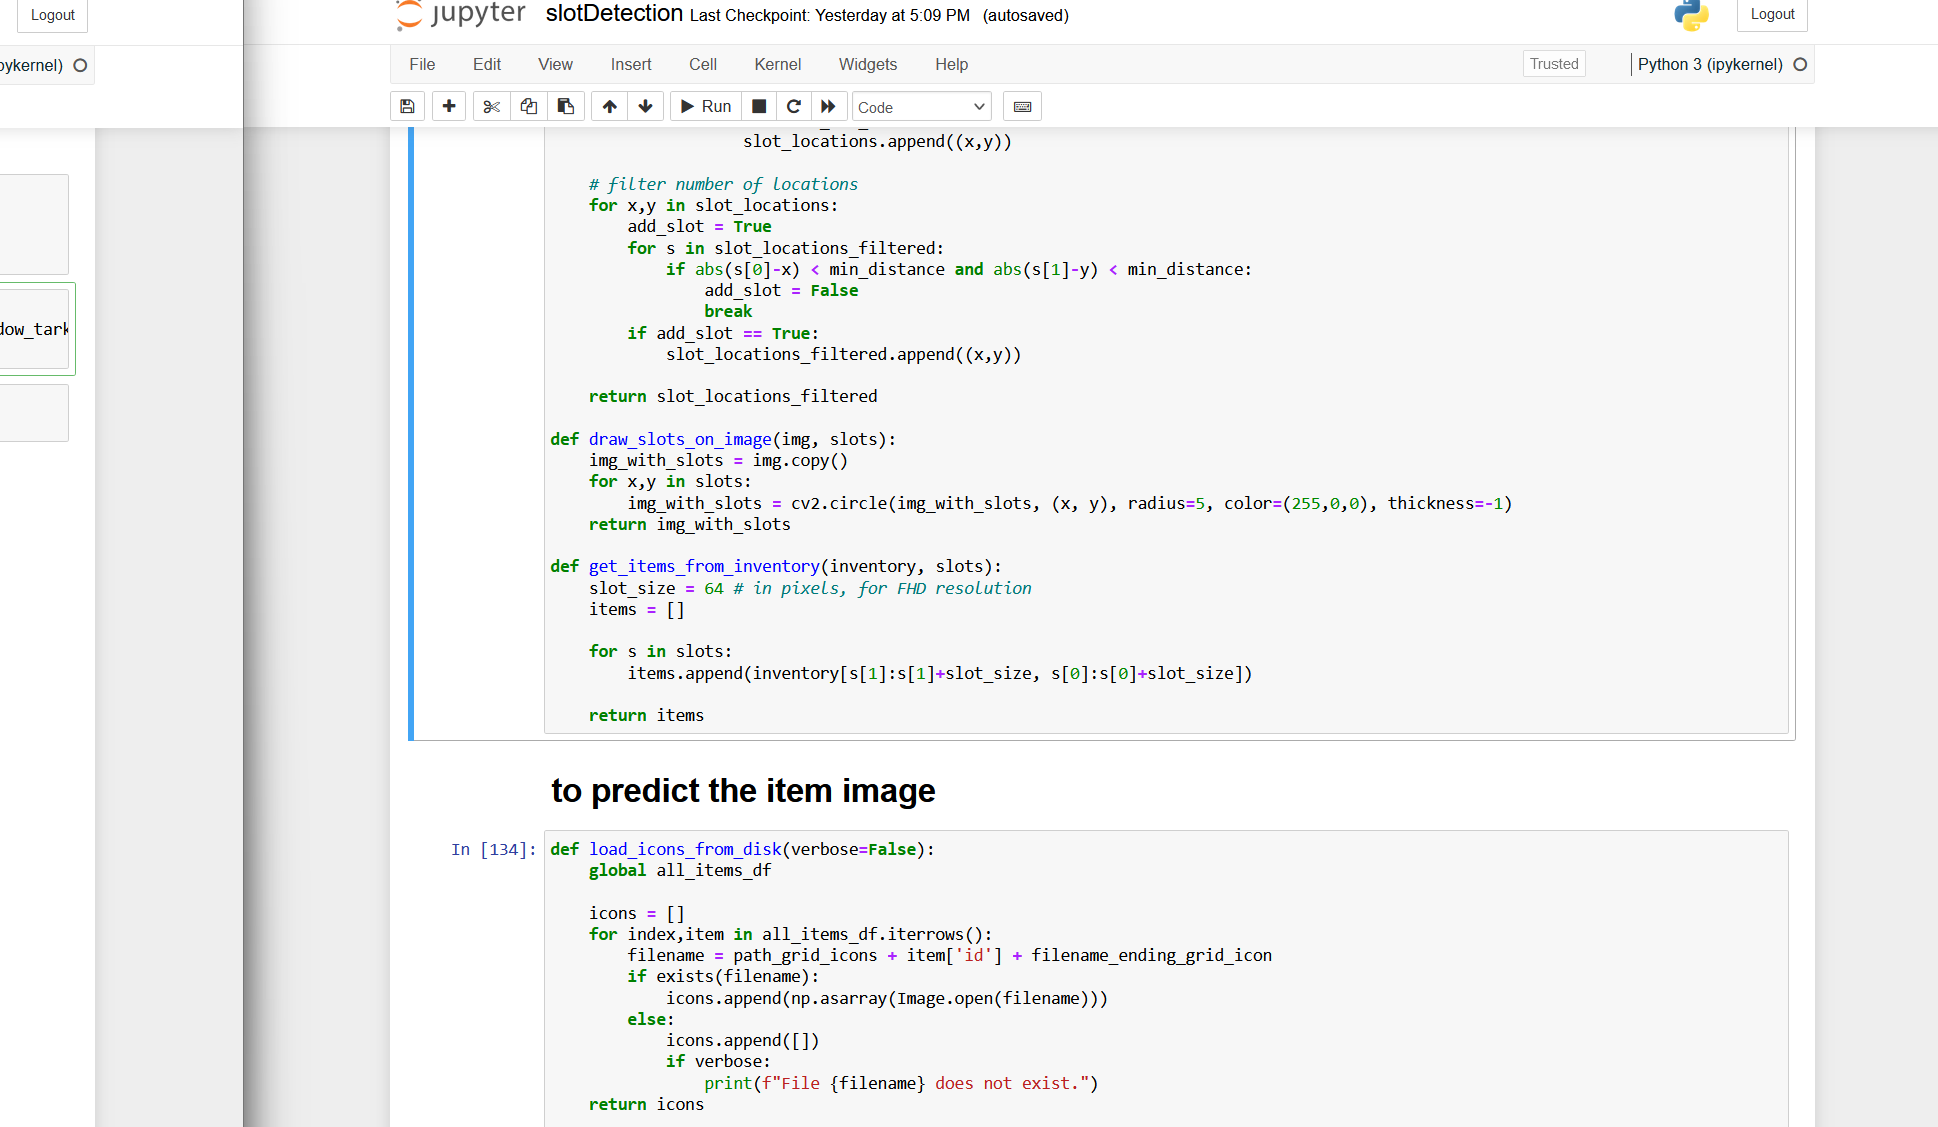

In [38]:
Image.fromarray(screenshot)

In [4]:
text_index = 1
texts = ['This is a label.', 'New text.']

def changeText():
    global text_index
    label['text'] = texts[text_index]
    text_index = -text_index + 1

In [11]:
def place_label(text, x, y):
    global root
    label = tk.Label(root, text=text, font=("helvetica", 30), fg='white', bg='black')
    label.place(x=x, y=y, anchor = 'nw')

In [6]:
# read predictions from file
predictions_df = pd.read_csv(path_data + 'predictions_inventar4.csv')

In [7]:
# load items for item prices
all_items_df = pd.read_csv(path_data + 'all_items.csv')

In [8]:
predictions_df

,slot_x,slot_y,predicted_item,distance
0,1452,74,1384,68170.144556
1,1085,99,2455,85551.545950
2,769,105,1703,38451.001016
3,1147,105,92,66751.777786
4,1336,105,92,66739.666621
...,...,...,...,...
214,832,925,204,100596.465589
215,958,925,204,93417.625570
216,1147,926,467,108301.024373
217,1273,926,1695,42904.902255


In [18]:
# find window position
x_window = window_tarkov_position[0]
y_window = window_tarkov_position[1]

# create the window
root = tk.Tk()
root.title("window title")
root.geometry("1920x1080+%d+%d" % (x_window,y_window))
root.attributes('-topmost', True)
root.overrideredirect(True)
root.configure(bg='red')

# make color red transparent
root.wm_attributes('-transparentcolor', 'black')

# create a transparent frame to make a border
my_frame = tk.Frame(root, width=1900, height=1060, bg='black')
my_frame.place(x=10,y=10)

# # add a label
# label = tk.Label(root, text="This is a label.", font=("helvetica", 30), fg='white', bg='black')
# label.place(x=50, y=50, anchor = 'nw')

# # add a button
# button = tk.Button(root, text='Change the text', command=changeText)
# button.pack()



# add all item prices
for prediction in predictions_df.iterrows():
    index = prediction[1][2]
    x = prediction[1][0]
    y = prediction[1][1]
    print(index)
    price_flea = all_items_df.loc[index, 'fleaMarket']
    
    if math.isnan(price_flea):
        continue
    price = (int) (all_items_df.loc[index, 'fleaMarket']/1000)
    price_string = str(price) + 'k'
    place_label(price_string, x, y)

# show the window and take focus
root.focus_force()
root.bind('<Escape>', lambda e: root.destroy())
root.mainloop()

1384.0
2098.0
1384.0
1384.0
2098.0
2713.0
1056.0
614.0
0.0
0.0
479.0
1949.0
1949.0
2528.0
126.0
0.0
613.0
1384.0
2098.0
1121.0
1402.0
1384.0
2098.0
2098.0
2236.0
0.0
0.0
0.0
2708.0
483.0
192.0
2098.0
1384.0
1708.0
1384.0
1384.0
0.0
0.0
0.0
949.0
2098.0
0.0
2098.0
284.0
288.0
471.0
471.0
1384.0
468.0
471.0
1860.0
204.0
611.0
204.0
2098.0
0.0
19.0
1384.0
2043.0
0.0
0.0
2098.0
611.0
1658.0
1323.0
1323.0
1324.0
1324.0
204.0
619.0
619.0
0.0
0.0
2148.0
0.0
0.0
949.0
0.0
1390.0
1699.0
1699.0
1715.0
644.0
0.0
2287.0
605.0
669.0
1695.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2500.0
669.0
0.0
1699.0
1699.0
190.0
1695.0
605.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1705.0
1705.0
1705.0
1705.0
1149.0
1149.0
205.0
206.0
1384.0
1711.0
466.0
0.0
1944.0
1384.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

In [20]:
all_items_df.loc[1384]

name                Mystery Ranch Blackjack 50 backpack (Multicam)
id                                        5c0e774286f77468413cc5b2
width                                                            5
height                                                           7
icon_width                                                    63.0
icon_height                                                   63.0
features                                                        []
fleaMarket                                                     NaN
flea_avg48                                                       0
flea_ch48percent                                               NaN
prapor                                                         NaN
therapist                                                      NaN
fence                                                      35200.0
skier                                                      43120.0
peacekeeper                                                   

In [15]:
gw.getWindowsWithTitle(window_title_tarkov)[0]

Win32Window(hWnd=529062)

In [10]:
gw.getAllTitles()

['',
 'NVIDIA GeForce Overlay DT',
 'overlay - Jupyter Notebook — Mozilla Firefox',
 'EscapeFromTarkov',
 'slotDetection - Jupyter Notebook — Mozilla Firefox',
 '',
 '',
 'Windows PowerShell',
 'C:\\Users\\Michael\\Desktop\\tarkovRat\\images',
 '',
 'PyGetWindow · PyPI — Mozilla Firefox',
 'Escape From Tarkov - Discord',
 'Settings',
 'Settings',
 'Steam',
 'NVIDIA GeForce Overlay',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Program Manager']

In [8]:
gw.getAllWindows()

[Win32Window(hWnd=135370),
 Win32Window(hWnd=66382),
 Win32Window(hWnd=529064),
 Win32Window(hWnd=529062),
 Win32Window(hWnd=722954),
 Win32Window(hWnd=659958),
 Win32Window(hWnd=2429160),
 Win32Window(hWnd=263238),
 Win32Window(hWnd=725272),
 Win32Window(hWnd=201324),
 Win32Window(hWnd=329698),
 Win32Window(hWnd=135444),
 Win32Window(hWnd=132228),
 Win32Window(hWnd=198084),
 Win32Window(hWnd=66844),
 Win32Window(hWnd=66376),
 Win32Window(hWnd=65960),
 Win32Window(hWnd=65950),
 Win32Window(hWnd=131270),
 Win32Window(hWnd=65908),
 Win32Window(hWnd=65906),
 Win32Window(hWnd=65904),
 Win32Window(hWnd=65902),
 Win32Window(hWnd=65768),
 Win32Window(hWnd=201080),
 Win32Window(hWnd=262570),
 Win32Window(hWnd=65846)]

In [35]:
all_items_df

,name,id,width,height,icon_width,icon_height,features,fleaMarket,flea_avg48,flea_ch48percent,prapor,therapist,fence,skier,peacekeeper,mechanic,ragman,jaeger
0,Colt M4A1 5.56x45 assault rifle,5447a9cd4bdc2dbd208b4567,1,1,316.0,127.0,"[(23, 25, 25)]",55000.0,80823,-45.34,9198.0,NaN,7358.0,NaN,84.0,10302.0,NaN,NaN
1,5.56x45mm M855 ammo pack (30 pcs),5447ac644bdc2d6c208b4567,1,1,64.0,64.0,"[(77, 80, 67)]",10000.0,0,0.00,NaN,NaN,400.0,NaN,NaN,NaN,NaN,NaN
2,Factory emergency exit key,5448ba0b4bdc2d02308b456c,1,1,64.0,64.0,"[(58, 52, 62)]",66888.0,81146,-3.46,25000.0,31500.0,20000.0,NaN,NaN,NaN,NaN,NaN
3,Makarov PM 9x18PM pistol,5448bd6b4bdc2dfc2f8b4569,2,1,63.0,64.0,[],6000.0,8814,11.72,2548.0,NaN,2038.0,NaN,23.0,2854.0,NaN,NaN
4,RGD-5 hand grenade,5448be9a4bdc2dfd2f8b456a,1,1,64.0,64.0,"[(36, 39, 37)]",11821.0,13412,-6.80,3615.0,NaN,2892.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,Oakley SI Batwolf glasses,62a61c988ec41a51b34758d5,2,1,63.0,64.0,[],16888.0,26974,0.37,NaN,NaN,7200.0,8820.0,82.0,NaN,11160.0,NaN
2719,Rogue USEC barrack key,62a9cb937377a65d7b070cef,1,1,64.0,64.0,"[(51, 61, 68)]",33333.0,35070,-3.51,20000.0,25200.0,16000.0,NaN,NaN,NaN,NaN,NaN
2720,Dogtag,customdogtags12345678910,1,1,64.0,64.0,"[(62, 70, 76)]",NaN,0,NaN,300.0,378.0,240.0,294.0,NaN,NaN,NaN,NaN
2721,Glock 17 9x19 pistol PS9,glock17ps900000000000001,2,1,63.0,64.0,[],NaN,0,0.00,29554.0,NaN,23643.0,NaN,269.0,33100.0,NaN,NaN
